In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [18]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
#MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
#MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
#MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir, sel='final')
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: smallgrp(120, 5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [19]:
def part_var(x, part, dim):
    '''
    Computes E[var(x | part)] / var(x), where part is a partition of x along dim.
    By the law of total variance, this quantity is in [0, 1].
    Stander et al instead compute (\sum_part var(x | part)) / var(x), which is less principled.
    '''
    part = list(map(list, part))
    assert sorted(sum(part, [])) == list(range(x.shape[dim])), "part must be a partition of x along dim"
    denom = x.var(dim=dim, correction=0)
    num = sum(
        x.index_select(dim, t.Tensor(p).int().to(x.device)).var(dim=dim, correction=0) * (len(p) / x.shape[dim])
        for p in part
    )
    return (num / denom).nan_to_num(nan=0.)

In [20]:
subgroups = group.get_subgroups_idx()

Computing subgroups from gap_repr


Computing elements: 100%|██████████████████████| 10/10 [00:00<00:00, 116.07it/s]


In [21]:
subgroups.keys()

dict_keys(['1', 'SL(2,5)', 'C2_0', 'C3_0', 'C3_1', 'C3_2', 'C3_3', 'C3_4', 'C3_5', 'C3_6', 'C3_7', 'C3_8', 'C3_9', 'C4_0', 'C4_1', 'C4_2', 'C4_3', 'C4_4', 'C4_5', 'C4_6', 'C4_7', 'C4_8', 'C4_9', 'C4_10', 'C4_11', 'C4_12', 'C4_13', 'C4_14', 'C5_0', 'C5_1', 'C5_2', 'C5_3', 'C5_4', 'C5_5', 'C6_0', 'C6_1', 'C6_2', 'C6_3', 'C6_4', 'C6_5', 'C6_6', 'C6_7', 'C6_8', 'C6_9', 'Q8_0', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'C10_0', 'C10_1', 'C10_2', 'C10_3', 'C10_4', 'C10_5', 'C3:C4_0', 'C3:C4_1', 'C3:C4_2', 'C3:C4_3', 'C3:C4_4', 'C3:C4_5', 'C3:C4_6', 'C3:C4_7', 'C3:C4_8', 'C3:C4_9', 'C5:C4_0', 'C5:C4_1', 'C5:C4_2', 'C5:C4_3', 'C5:C4_4', 'C5:C4_5', 'SL(2,3)_0', 'SL(2,3)_1', 'SL(2,3)_2', 'SL(2,3)_3', 'SL(2,3)_4'])

In [8]:
left_cosets = {
    name: data.groups[0].get_cosets_idx(subgroup, left=True)
    for name, subgroup in subgroups.items()
}
right_cosets = {
    name: data.groups[0].get_cosets_idx(subgroup, left=False)
    for name, subgroup in subgroups.items()
}

In [9]:
loss_dict = test_loss(models[-1].to(device), data)
instance = loss_dict['G0_acc'].argmax().item()
model = models[0][instance]
instance

0

In [10]:
left_neurons, right_neurons = model.get_neurons()
left_neurons = left_neurons.squeeze(0)
right_neurons = right_neurons.squeeze(0)
unembed = model.unembedding.data.squeeze(0)

In [11]:
# hypothesis is that left neurons are constant on *right* cosets
left_coset_vars = {
    name: part_var(left_neurons, right_cosets[name], dim=0)
    for name in right_cosets.keys()
}

In [16]:
left_neuron_cosets = dict()
for neuron in range(left_neurons.shape[1]):
    left_neuron_cosets[neuron] = None
    for name, subgroup in subgroups.items():
        if left_coset_vars[name][neuron] < 0.01:
            if left_neuron_cosets[neuron] is None or len(left_neuron_cosets[neuron]) < len(subgroup):
                left_neuron_cosets[neuron] = name

In [17]:
subgroup_counts = defaultdict(lambda: 0)
for name in left_neuron_cosets.values():
    subgroup_counts[name] += 1    
subgroup_counts

defaultdict(<function __main__.<lambda>()>,
            {'C10_3': 15,
             'C11_0': 14,
             'C10_1': 13,
             '1': 77,
             'C10_10': 15,
             'C10_8': 15,
             'C10_2': 15,
             'C10_4': 15,
             'C10_5': 16,
             'C10_6': 17,
             'C10_9': 12,
             'C10_0': 14,
             'C10_7': 16,
             'C11:C5_0': 2})

In [30]:
coset_neurons = [i for i, name in left_neuron_cosets.items() if 'SL(2,3)' in name]

In [31]:
len(coset_neurons)

62

In [52]:
irrep1_neurons = [0,1,3,6,11,13,16,17,18,20,22,23,24,26,28,30,31,32,33,34,35,37,38,39,40,41,42,43,45,47,48,49,51,54,56,58,59,60,61,62,64,66,67,69,70,71,73,74,75,77,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,100,101,102,103,104,106,107,108,109,110,111,112,113,114,115,116,117,120,121,122,123,124,125,126,127,129,130,131,133,134,135,137,138,140,141,145,146,147,150,152,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,179,180,181,182,183,184,185,186,188,189,192,194,195,196,199,201,202,203,204,206,208,212,216,218,219,220,221,223,224,225,227,229,230,231,232,233,234,236,237,238,239,240,241,242,246,247,248,250,253,255]

In [38]:
irrep2_neurons = [2, 4, 7, 10, 12, 14, 15, 19, 21, 25, 44, 50, 52, 53, 55, 65, 68, 72, 79, 92, 96, 118, 119, 128, 132, 136, 139, 142, 143, 144, 148, 149, 153, 178, 197, 198, 200, 205, 207, 209, 211, 213, 214, 215, 217, 222, 226, 228, 235, 244, 252, 254]

In [34]:
len(set(coset_neurons) & set(irrep2_neurons))

52

In [53]:
ablate_model = copy.deepcopy(model)

In [54]:
ablate_model.unembedding.data[0,irrep1_neurons,:] = 0.

In [55]:
loss_dict = test_loss(model.to(device), data)
ablate_loss_dict = test_loss(ablate_model.to(device), data)

In [56]:
loss_dict['G0_acc'], ablate_loss_dict['G0_acc']

(tensor([0.9995], device='cuda:0'), tensor([0.5283], device='cuda:0'))

In [ ]:
loss_dict['G0_acc'], ablate_loss_dict['G0_acc']

In [59]:
class Abs(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale

    def forward(self, input: t.Tensor) -> t.Tensor:
        return t.abs(input) * self.scale

In [61]:
abs_model = copy.deepcopy(model)
abs_model.activation = Abs(scale=1.)

In [66]:
ablate_model = copy.deepcopy(abs_model)
ablate_model.unembedding.data[0,coset_neurons,:] = 0.
loss_dict = test_loss(abs_model.to(device), data)
ablate_loss_dict = test_loss(ablate_model.to(device), data)
loss_dict['G0_acc'], ablate_loss_dict['G0_acc']

(tensor([0.9818], device='cuda:0'), tensor([0.1473], device='cuda:0'))

In [58]:
ablate_model.unembedding.data[0,irrep1_neurons,:].shape

torch.Size([182, 120])

'2, 4, 7, 10, 12, 14, 15, 19, 21, 25, 44, 50, 52, 53, 55, 65, 68, 72, 79, 92, 96, 118, 119, 128, 132, 136, 139, 142, 143, 144, 148, 149, 153, 178, 197, 198, 200, 205, 207, 209, 211, 213, 214, 215, 217, 222, 226, 228, 235, 244, 252, 254'

### stuff for intersection of multiple groups

In [7]:
subgroups = {
    i: {sg for sg in data.groups[i].get_subgroups_idx()}
    for i in range(len(data.groups))
}

In [ ]:
left_cosets = {
    i: {
        subgroup: data.groups[i].get_cosets_idx(subgroup, left=True)
        for subgroup in subgroups[i]
    }
    for i in range(len(data.groups))
}
right_cosets = {
    i: {
        subgroup: data.groups[i].get_cosets_idx(subgroup, left=False)
        for subgroup in subgroups[i]
    }
    for i in range(len(data.groups))
}

In [9]:
loss_dict = test_loss(models[-1].to(device), data)

In [10]:
instance = loss_dict['G0_loss'].argmin().item()
model = models[0][instance]
instance

19

In [11]:
left_neurons, right_neurons = model.get_neurons()
left_neurons = left_neurons.squeeze(0)
right_neurons = right_neurons.squeeze(0)
unembed = model.unembedding.data.squeeze(0)

In [12]:
# hypothesis is that left neurons are constant on *right* cosets
left_coset_vars = {
    i: {
        subgroup: part_var(left_neurons, right_cosets[i][subgroup], dim=0)
        for subgroup in right_cosets[i].keys()
    }
    for i in range(len(data.groups))
}

In [13]:
left_neuron_cosets = dict()
group = 0
for neuron in range(left_neurons.shape[1]):
    left_neuron_cosets[neuron] = None
    for subgroup in subgroups[group]:
        if left_coset_vars[group][subgroup][neuron] < 0.05:
            if left_neuron_cosets[neuron] is None or len(left_neuron_cosets[neuron]) < len(subgroup):
                left_neuron_cosets[neuron] = subgroup

In [14]:
named_subgroups = {}
order_counts = defaultdict(lambda: 0)
for s in subgroups[0]:
    named_subgroups[s] = f'{len(s)}^{order_counts[len(s)]}'
    order_counts[len(s)] += 1

In [34]:
# named_subgroups = {
#     # [s for s in subgroups[0] if len(s) == 1][0]: 'e',
#     # [s for s in subgroups[0] if len(s) == 60][0]: 'A5',
#     # [s for s in subgroups[0] if len(s) == 120][0]: 'S5',
# }
# A4_count = 0
# S4_count = 0
# order_counts = defaultdict(lambda: 0)
# for s in subgroups[0]:
#     # if len(s) == 24:
#     #     named_subgroups[s] = f'S_4^{S4_count}'  # not the correct index but whatever
#     #     S4_count += 1
#     # elif len(s) == 12:
#     #     named_subgroups[s] = f'A_4^{A4_count}'  # not the correct index but whatever
#     #     A4_count += 1
#     # elif len(s) not in [1, 60, 120]:
#     named_subgroups[s] = f'{len(s)}^{order_counts[len(s)]}'
#     order_counts[len(s)] += 1
        

In [15]:
named_subgroups.values()

dict_values(['4^0', '24^0', '4^1', '5^0', '20^0', '12^0', '20^1', '8^0', '12^1', '10^0', '12^2', '4^2', '4^3', '6^0', '10^1', '12^3', '20^2', '8^1', '3^0', '10^2', '4^4', '4^5', '3^1', '5^1', '5^2', '5^3', '6^1', '4^6', '4^7', '24^1', '4^8', '12^4', '12^5', '20^3', '6^2', '3^2', '20^4', '8^2', '120^0', '6^3', '12^6', '5^4', '8^3', '6^4', '8^4', '3^3', '10^3', '24^2', '5^5', '20^5', '4^9', '12^7', '12^8', '12^9', '3^4', '10^4', '24^3', '3^5', '3^6', '3^7', '4^10', '6^5', '6^6', '3^8', '10^5', '2^0', '4^11', '6^7', '4^12', '4^13', '6^8', '24^4', '4^14', '6^9', '1^0', '3^9'])

In [16]:
subgroup_counts = defaultdict(lambda: 0)
for subgroup in left_neuron_cosets.values():
    subgroup_counts[named_subgroups[subgroup]] += 1    
subgroup_counts

defaultdict(<function __main__.<lambda>()>,
            {'1^0': 193,
             '24^1': 13,
             '24^4': 11,
             '24^3': 11,
             '120^0': 10,
             '24^2': 8,
             '24^0': 9,
             '8^0': 1})

In [22]:
sum(v for k, v in subgroup_counts.items() if k[:2] == '22')

15

In [35]:
left_neurons[:,5]

tensor([ 1.4387, -1.3587, -0.5878,  1.3946, -0.9514, -1.3291,  1.3779, -0.1067,
        -1.3367,  1.4713,  0.5336, -1.3958,  1.4846,  1.1526, -1.4805,  0.8456,
         1.4523, -1.3150, -0.1339,  1.4530, -1.3726, -0.8427,  1.3948, -1.0892,
        -1.3235,  1.3824, -0.2205, -1.3608,  1.4080,  0.3538, -1.4622,  1.4078,
         0.9273, -1.3610,  0.5298,  1.3975, -1.4515, -0.2364,  1.3996, -1.2899,
        -0.8234,  1.4117, -1.1671, -1.2806,  1.2976,  0.0364, -1.4376,  1.3411,
         0.5346, -1.3954,  1.1754,  0.9966, -1.3593,  0.8908,  1.3968, -1.4744,
         0.0745])

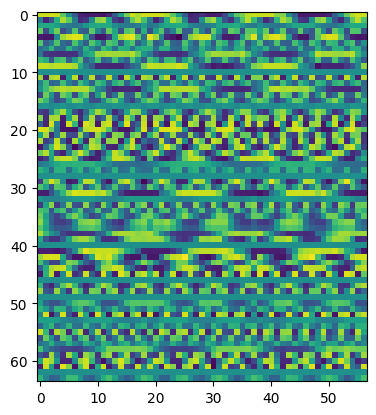

In [36]:
plt.imshow(left_neurons.numpy().T)

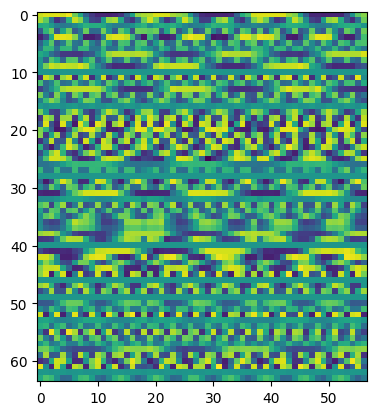

In [37]:
plt.imshow(right_neurons.numpy().T)

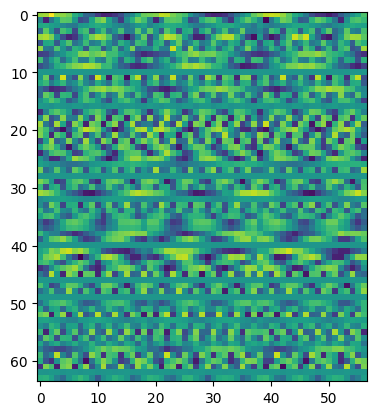

In [38]:
plt.imshow(unembed.numpy())